In [1]:
!pip install hypernetx matplotlib scikit-learn


In [2]:
!pip install networkx numpy scikit-learn matplotlib

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
import networkx as nx
import numpy as np
from sklearn.cluster import SpectralClustering
import matplotlib.pyplot as plt

# Step 1: Load the undirected YouTube network data from the file
def load_undirected_youtube_data(filename,limit=100):
    G = nx.Graph()  # Create an undirected graph
    with open(filename, 'r') as f:
        for line in f:
            if line.startswith("#"):  # Skip comment lines
                continue
            parts = line.strip().split()
            node1 = int(parts[0])  # First node in the edge
            node2 = int(parts[1])  # Second node in the edge
            G.add_edge(node1, node2)  # Add an undirected edge between the nodes
    return G

# Step 2: Compute the Laplacian matrix
def compute_laplacian(G):
    # Get the Laplacian matrix of the graph
    L = nx.laplacian_matrix(G).toarray()
    return L

# Step 3: Perform Spectral Clustering
def spectral_clustering_on_graph(L, num_clusters=5):
    # Use spectral clustering on the Laplacian matrix
    clustering = SpectralClustering(n_clusters=num_clusters, affinity='precomputed', assign_labels='kmeans')
    clustering.fit(L)
    return clustering.labels_

# Step 4: Visualize the clusters
def visualize_clusters(G, labels):
    # Create a layout for the graph nodes
    pos = nx.spring_layout(G)  # Spring layout for better visualization

    # Draw the graph with node colors based on cluster labels
    plt.figure(figsize=(12, 8))
    nx.draw(G, pos, node_color=labels, with_labels=False, node_size=20, cmap=plt.cm.rainbow)
    plt.title('Spectral Clustering of YouTube Network')
    plt.show()


In [6]:
#filename = '/content/drive/My Drive/CSE551/Undirected.txt'

In [ ]:
# Main function to run the process
def main():
    filename = '/content/drive/My Drive/CSE551/Undirected.txt'

    # Step 1: Load the data
    print("Loading YouTube network data...")
    G = load_undirected_youtube_data(filename)
    print(f"Graph has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")

    # Step 2: Compute the Laplacian matrix
    print("Computing the Laplacian matrix...")
    L = compute_laplacian(G)

    # Step 3: Perform spectral clustering
    num_clusters = 5  # Set the number of clusters
    print(f"Performing spectral clustering with {num_clusters} clusters...")
    labels = spectral_clustering_on_graph(L, num_clusters=num_clusters)

    # Step 4: Visualize the results
    print("Visualizing the clusters...")
    visualize_clusters(G, labels)

if __name__ == "__main__":
    main()


Loading YouTube network data...
Graph has 1134890 nodes and 2987624 edges.
Computing the Laplacian matrix...




---



---



---



In [17]:
import networkx as nx
import numpy as np
from sklearn.cluster import SpectralClustering
import matplotlib.pyplot as plt
from scipy.sparse import csgraph
from scipy.sparse import lil_matrix, csr_matrix

# Step 1: Load the undirected YouTube network data (limiting edges)
def load_undirected_youtube_data(filename, limit=500):
    G = nx.Graph()  # Create an undirected graph
    edge_count = 0
    with open(filename, 'r') as f:
        for line in f:
            if line.startswith("#"):  # Skip comment lines
                continue
            parts = line.strip().split()
            node1 = int(parts[0])  # First node in the edge
            node2 = int(parts[1])  # Second node in the edge
            G.add_edge(node1, node2)  # Add an undirected edge between the nodes
            edge_count += 1
            if edge_count >= limit:  # Stop after loading 'limit' edges
                break
    return G

# Step 2: Remove isolated nodes from the graph
def remove_isolated_nodes(G):
    isolated_nodes = list(nx.isolates(G))
    G.remove_nodes_from(isolated_nodes)
    return G

# Step 3: Compute the sparse Laplacian matrix
def compute_sparse_laplacian(G):
    L = nx.normalized_laplacian_matrix(G)  # Compute the normalized Laplacian
    return L

# Step 4: Convert sparse matrix to 32-bit integer indices
def convert_to_32bit(L):
    L_32 = L.astype(np.float64).tocsc()  # Ensure it's in compressed sparse column format
    L_32.indices = L_32.indices.astype(np.int32)
    L_32.indptr = L_32.indptr.astype(np.int32)
    return L_32

# Step 5: Check for NaN values in the sparse Laplacian matrix
def handle_nan_values(L):
    # Convert to dense matrix for NaN checking
    L_dense = L.toarray()
    L_dense[np.isnan(L_dense)] = 0  # Replace any NaN values with 0s
    return csr_matrix(L_dense)  # Convert back to sparse format

# Step 6: Perform Spectral Clustering on sparse matrix
def spectral_clustering_on_sparse_laplacian(L, num_clusters=5):
    # Convert sparse matrix to dense format for clustering
    L_dense = L.toarray()

    # Ensure no NaN values exist in the dense matrix (replace them with 0 as a final check)
    L_dense[np.isnan(L_dense)] = 0

    # Use spectral clustering on the cleaned dense Laplacian matrix
    clustering = SpectralClustering(n_clusters=num_clusters, affinity='precomputed', assign_labels='kmeans')
    clustering.fit(L_dense)
    return clustering.labels_

# Step 7: Visualize the clusters
def visualize_clusters(G, labels):
    # Create a layout for the graph nodes
    pos = nx.spring_layout(G, seed=42)  # Spring layout for better visualization

    # Draw the graph with node colors based on cluster labels
    plt.figure(figsize=(12, 8))
    nx.draw(G, pos, node_color=labels, with_labels=False, node_size=20, cmap=plt.cm.rainbow)
    plt.title('Spectral Clustering of YouTube Network (Sampled Data)')
    plt.show()


In [18]:
# Main function to run the process
def main():
    filename = '/content/drive/My Drive/CSE551/Undirected.txt'  # Path to your file

    # Step 1: Load the data (limit to first 500 edges)
    print("Loading YouTube network data (sampled edges)...")
    G = load_undirected_youtube_data(filename, limit=500)  # Limiting to 500 edges
    print(f"Graph has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")

    # Step 2: Remove isolated nodes
    print("Removing isolated nodes...")
    G = remove_isolated_nodes(G)
    print(f"After removing isolated nodes: {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")

    # Step 3: Compute the Laplacian matrix in sparse format
    print("Computing the sparse Laplacian matrix...")
    L = compute_sparse_laplacian(G)

    # Step 4: Convert sparse matrix to 32-bit indices
    print("Converting sparse matrix to 32-bit indices...")
    L_32 = convert_to_32bit(L)

    # Step 5: Handle NaN values in the Laplacian matrix
    print("Handling NaN values in the Laplacian matrix...")
    L_32_clean = handle_nan_values(L_32)

    # Step 6: Perform spectral clustering
    num_clusters = 5  # Set the number of clusters
    print(f"Performing spectral clustering with {num_clusters} clusters...")
    labels = spectral_clustering_on_sparse_laplacian(L_32_clean, num_clusters=num_clusters)

    # Step 7: Visualize the results
    print("Visualizing the clusters...")
    visualize_clusters(G, labels)

if __name__ == "__main__":
    main()


Loading YouTube network data (sampled edges)...
Graph has 466 nodes and 500 edges.
Removing isolated nodes...
After removing isolated nodes: 466 nodes and 500 edges.
Computing the sparse Laplacian matrix...


TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''



---



---



---



# ***Apply k-means clustering on the Laplacian eigenvectors***

In [26]:
import networkx as nx
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from scipy.sparse.csgraph import laplacian
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import eigsh

# Step 1: Load the undirected YouTube network data (limiting edges)
def load_undirected_youtube_data(filename, limit=500):
    G = nx.Graph()  # Create an undirected graph
    edge_count = 0
    with open(filename, 'r') as f:
        for line in f:
            if line.startswith("#"):  # Skip comment lines
                continue
            parts = line.strip().split()
            node1 = int(parts[0])  # First node in the edge
            node2 = int(parts[1])  # Second node in the edge
            G.add_edge(node1, node2)  # Add an undirected edge between the nodes
            edge_count += 1
            if edge_count >= limit:  # Stop after loading 'limit' edges
                break
    return G

# Step 2: Remove isolated nodes from the graph
def remove_isolated_nodes(G):
    isolated_nodes = list(nx.isolates(G))
    G.remove_nodes_from(isolated_nodes)
    return G

# Step 3: Compute the sparse Laplacian matrix using scipy
def compute_sparse_laplacian(G):
    adjacency_matrix = nx.adjacency_matrix(G)  # Get the adjacency matrix
    L = laplacian(adjacency_matrix, normed=True)  # Compute the normalized Laplacian matrix
    return csr_matrix(L)  # Return as a sparse matrix

# Step 4: Get the eigenvectors of the Laplacian matrix
def get_laplacian_eigenvectors(L, num_clusters=5):
    # Compute the smallest 'num_clusters' eigenvectors
    eigenvalues, eigenvectors = eigsh(L, k=num_clusters, which='SM')
    return eigenvectors

# Step 5: Apply k-means on the Laplacian's eigenvectors
def spectral_clustering_kmeans(eigenvectors, num_clusters=5):
    kmeans = KMeans(n_clusters=num_clusters)
    labels = kmeans.fit_predict(eigenvectors)  # Apply k-means on the eigenvectors
    return labels

# Step 6: Visualize the clusters
def visualize_clusters(G, labels):
    # Create a layout for the graph nodes
    pos = nx.spring_layout(G, seed=42)  # Spring layout for better visualization

    # Draw the graph with node colors based on cluster labels
    plt.figure(figsize=(12, 8))
    nx.draw(G, pos, node_color=labels, with_labels=False, node_size=20, cmap=plt.cm.rainbow)
    plt.title('Spectral Clustering of YouTube Network (Sampled Data)')
    plt.show()



Loading YouTube network data (sampled edges)...
Graph has 466 nodes and 500 edges.
Removing isolated nodes...
After removing isolated nodes: 466 nodes and 500 edges.
Computing the sparse Laplacian matrix...
Computing eigenvectors of the Laplacian matrix...
Applying k-means clustering...
Visualizing the clusters...


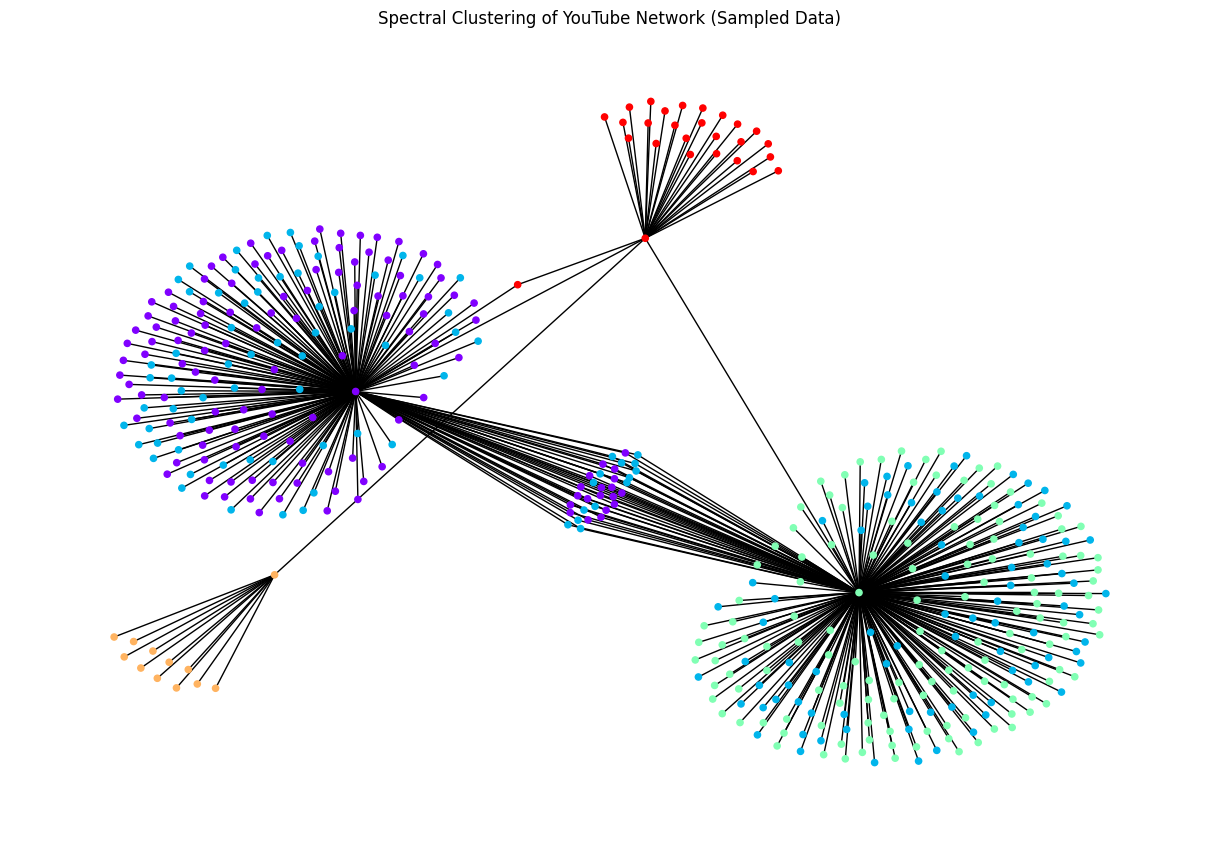

In [27]:
# Main function to run the process
def main():
    filename = '/content/drive/My Drive/CSE551/Undirected.txt'  # Path to your file

    # Step 1: Load the data (limit to first 500 edges)
    print("Loading YouTube network data (sampled edges)...")
    G = load_undirected_youtube_data(filename, limit=500)  # Limiting to 500 edges
    print(f"Graph has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")

    # Step 2: Remove isolated nodes
    print("Removing isolated nodes...")
    G = remove_isolated_nodes(G)
    print(f"After removing isolated nodes: {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")

    # Step 3: Compute the Laplacian matrix in sparse format
    print("Computing the sparse Laplacian matrix...")
    L = compute_sparse_laplacian(G)

    # Step 4: Get the eigenvectors of the Laplacian matrix
    print("Computing eigenvectors of the Laplacian matrix...")
    eigenvectors = get_laplacian_eigenvectors(L, num_clusters=5)

    # Step 5: Perform clustering using k-means on the eigenvectors
    print("Applying k-means clustering...")
    labels = spectral_clustering_kmeans(eigenvectors, num_clusters=5)

    # Step 6: Visualize the results
    print("Visualizing the clusters...")
    visualize_clusters(G, labels)

if __name__ == "__main__":
    main()

Loading YouTube network data (sampled edges)...
Graph has 937 nodes and 1000 edges.
Removing isolated nodes...
After removing isolated nodes: 937 nodes and 1000 edges.
Computing the sparse Laplacian matrix...
Computing eigenvectors of the Laplacian matrix...
Applying k-means clustering...
Visualizing the clusters...


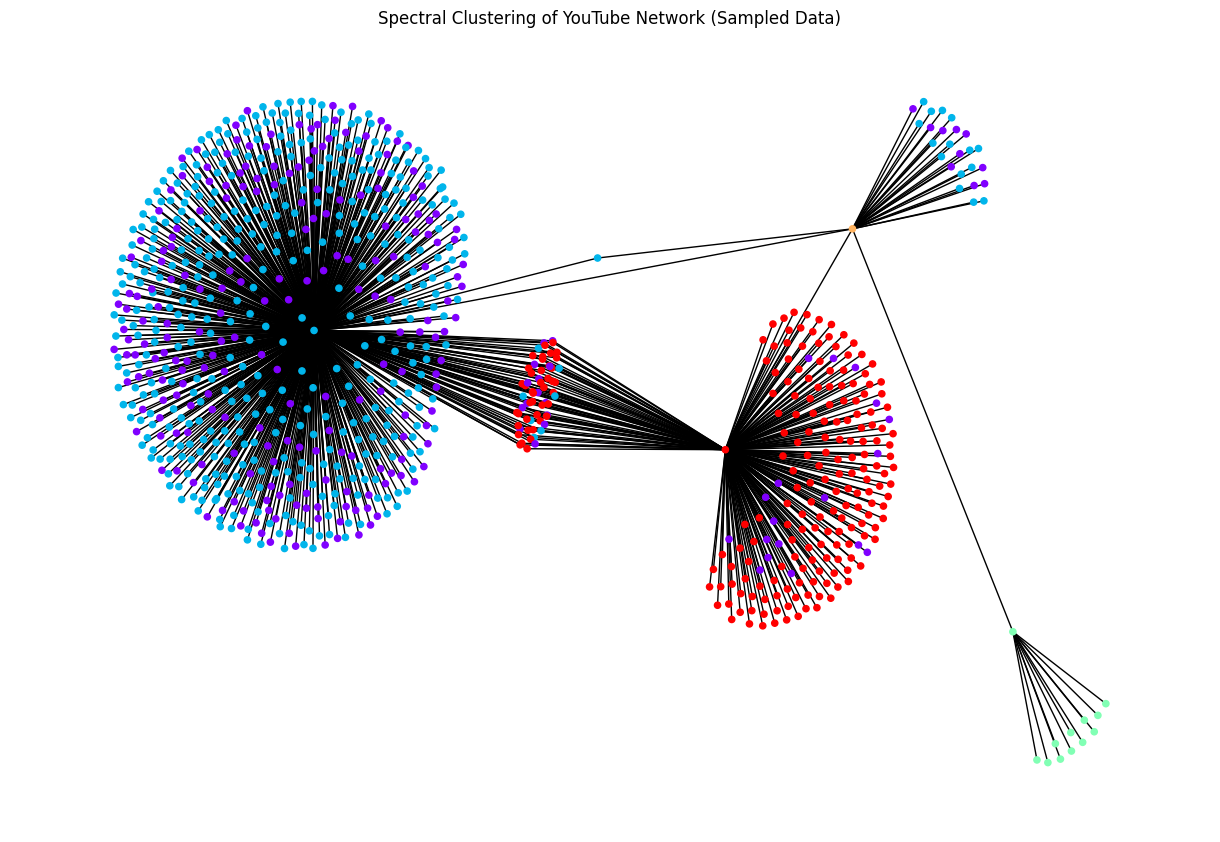

In [25]:
# Main function to run the process
def main():
    filename = '/content/drive/My Drive/CSE551/Undirected.txt'  # Path to your file

    # Step 1: Load the data (limit to first 500 edges)
    print("Loading YouTube network data (sampled edges)...")
    G = load_undirected_youtube_data(filename, limit=1000)  # Limiting to 500 edges
    print(f"Graph has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")

    # Step 2: Remove isolated nodes
    print("Removing isolated nodes...")
    G = remove_isolated_nodes(G)
    print(f"After removing isolated nodes: {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")

    # Step 3: Compute the Laplacian matrix in sparse format
    print("Computing the sparse Laplacian matrix...")
    L = compute_sparse_laplacian(G)

    # Step 4: Get the eigenvectors of the Laplacian matrix
    print("Computing eigenvectors of the Laplacian matrix...")
    eigenvectors = get_laplacian_eigenvectors(L, num_clusters=5)

    # Step 5: Perform clustering using k-means on the eigenvectors
    print("Applying k-means clustering...")
    labels = spectral_clustering_kmeans(eigenvectors, num_clusters=5)

    # Step 6: Visualize the results
    print("Visualizing the clusters...")
    visualize_clusters(G, labels)

if __name__ == "__main__":
    main()



---



---



---



In [27]:
import networkx as nx
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from scipy.sparse.csgraph import laplacian
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import eigsh

# Step 1: Load the undirected YouTube network data (limiting edges)
def load_undirected_youtube_data(filename, limit=500):
    G = nx.Graph()  # Create an undirected graph
    edge_count = 0
    with open(filename, 'r') as f:
        for line in f:
            if line.startswith("#"):  # Skip comment lines
                continue
            parts = line.strip().split()
            node1 = int(parts[0])  # First node in the edge
            node2 = int(parts[1])  # Second node in the edge
            G.add_edge(node1, node2)  # Add an undirected edge between the nodes
            edge_count += 1
            if edge_count >= limit:  # Stop after loading 'limit' edges
                break
    return G

# Step 2: Remove isolated nodes from the graph
def remove_isolated_nodes(G):
    isolated_nodes = list(nx.isolates(G))
    G.remove_nodes_from(isolated_nodes)
    return G

# Step 3: Compute the sparse Laplacian matrix using scipy
def compute_sparse_laplacian(G):
    adjacency_matrix = nx.adjacency_matrix(G)  # Get the adjacency matrix
    L = laplacian(adjacency_matrix, normed=True)  # Compute the normalized Laplacian matrix
    return csr_matrix(L)  # Return as a sparse matrix

# Step 4: Get the eigenvectors of the Laplacian matrix
def get_laplacian_eigenvectors(L, num_clusters=5):
    # Compute the smallest 'num_clusters' eigenvectors
    eigenvalues, eigenvectors = eigsh(L, k=num_clusters, which='SM')
    print(f"Eigenvalues:\n{eigenvalues}\n")  # Print the eigenvalues for each cluster
    return eigenvectors

# Step 5: Apply k-means on the Laplacian's eigenvectors
def spectral_clustering_kmeans(eigenvectors, num_clusters=5):
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    labels = kmeans.fit_predict(eigenvectors)  # Apply k-means on the eigenvectors
    print(f"Cluster labels for nodes:\n{labels}\n")  # Print the cluster labels
    return labels

# Step 6: Visualize the clusters
def visualize_clusters(G, labels):
    # Create a layout for the graph nodes
    pos = nx.spring_layout(G, seed=42)  # Spring layout for better visualization

    # Draw the graph with node colors based on cluster labels
    plt.figure(figsize=(12, 8))
    nx.draw(G, pos, node_color=labels, with_labels=False, node_size=20, cmap=plt.cm.rainbow)
    plt.title('Spectral Clustering of YouTube Network (Sampled Data)')
    plt.show()


Loading YouTube network data (sampled edges)...
Graph has 466 nodes and 500 edges.

Removing isolated nodes...
After removing isolated nodes: 466 nodes and 500 edges.

Computing the sparse Laplacian matrix...
Sparse Laplacian matrix shape: (466, 466)

Computing eigenvectors of the Laplacian matrix...
First 5 eigenvectors (rows):
[[-1.70293864e-01  3.75485468e-01  4.31611854e-01  3.79090797e-01
   0.00000000e+00]
 [-5.05964426e-01 -1.50375749e-01 -3.43890213e-01  3.21065143e-01
   0.00000000e+00]
 [-1.09544512e-01  5.80583908e-01 -3.10584057e-01 -2.33366400e-01
   0.00000000e+00]
 [-4.54972527e-01 -1.00996463e-01  3.01077087e-01 -4.38287308e-01
  -2.08166817e-17]
 [-3.16227766e-02  7.15197299e-02  8.70322016e-02  7.69452076e-02
   3.81770103e-02]]

Applying k-means clustering...
Visualizing the clusters...


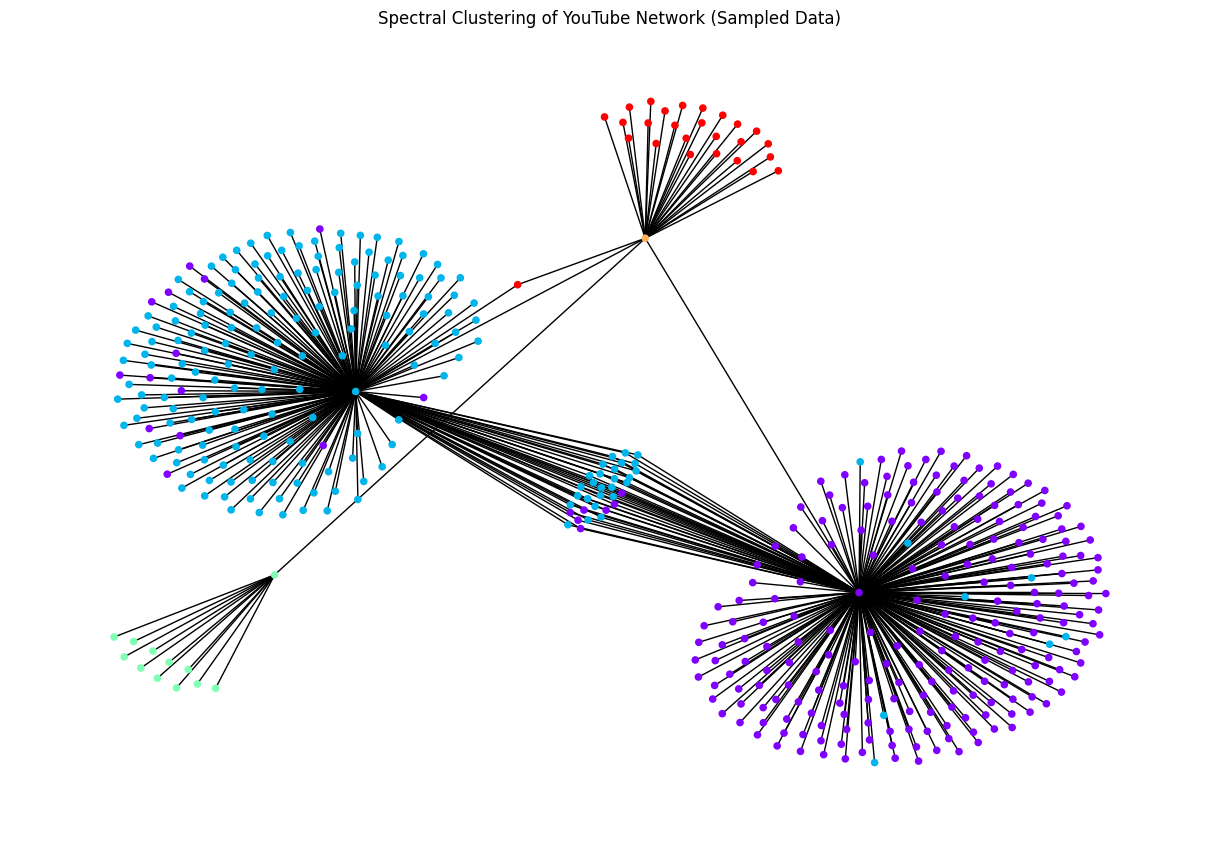

In [28]:
# Main function to run the process
def main():
    filename = '/content/drive/My Drive/CSE551/Undirected.txt'  # Path to your file

    # Step 1: Load the data (limit to first 500 edges)
    print("Loading YouTube network data (sampled edges)...")
    G = load_undirected_youtube_data(filename, limit=500)  # Limiting to 500 edges
    print(f"Graph has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.\n")

    # Step 2: Remove isolated nodes
    print("Removing isolated nodes...")
    G = remove_isolated_nodes(G)
    print(f"After removing isolated nodes: {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.\n")

    # Step 3: Compute the Laplacian matrix in sparse format
    print("Computing the sparse Laplacian matrix...")
    L = compute_sparse_laplacian(G)
    print(f"Sparse Laplacian matrix shape: {L.shape}\n")

    # Step 4: Get the eigenvectors of the Laplacian matrix
    print("Computing eigenvectors of the Laplacian matrix...")
    eigenvectors = get_laplacian_eigenvectors(L, num_clusters=5)
    print(f"First 5 eigenvectors (rows):\n{eigenvectors[:5]}\n")  # Show first 5 rows of eigenvectors

    # Step 5: Perform clustering using k-means on the eigenvectors
    print("Applying k-means clustering...")
    labels = spectral_clustering_kmeans(eigenvectors, num_clusters=5)

    # Step 6: Visualize the results
    print("Visualizing the clusters...")
    visualize_clusters(G, labels)

if __name__ == "__main__":
    main()



---



---



---



# ***HyperNetX And Louvian***